In [1]:
import pnet_loader
import util
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import Pnet
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import os

%load_ext autoreload
%autoreload 2

In [23]:
a = torch.ones(10, 5, 3)

In [35]:
cnn1 = torch.nn.Conv1d(5, 5, 3, bias=False)
torch.nn.init.ones_(cnn1.weight)

Parameter containing:
tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], requires_grad=True)

In [36]:
cnn1(a)

tensor([[[15.],
         [15.],
         [15.],
         [15.],
         [15.]],

        [[15.],
         [15.],
         [15.],
         [15.],
         [15.]],

        [[15.],
         [15.],
         [15.],
         [15.],
         [15.]],

        [[15.],
         [15.],
         [15.],
         [15.],
         [15.]],

        [[15.],
         [15.],
         [15.],
         [15.],
         [15.]],

        [[15.],
         [15.],
         [15.],
         [15.],
         [15.]],

        [[15.],
         [15.],
         [15.],
         [15.],
         [15.]],

        [[15.],
         [15.],
         [15.],
         [15.],
         [15.]],

        [[15.],
         [15.],
         [15.],
         [15.],
         [15.]],

        [[15.],
         [15.],
         [15.],
         [15.],
         [15.]]], grad_fn=<ConvolutionBackward0>)

In [4]:
directories = ['../data/' + x for x in os.listdir('../data/') if 'tcga_pan_can_atlas' in x]

In [5]:
def load_single_dataset(directory_path):
    rna_exp = pd.read_csv(directory_path + '/data_mrna_seq_v2_rsem.txt',
                           sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    rna_exp = rna_exp.loc[:,~rna_exp.columns.duplicated()].astype(float).copy()
    cna = pd.read_csv(directory_path + '/data_cna.txt',
                      sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    cna.drop('Cytoband', errors='ignore', inplace=True)
    cna = cna.loc[:,~cna.columns.duplicated()].astype(float).copy()
    
    genes = list(set(rna_exp.columns).intersection(cna.columns))
    indices = list(set(rna_exp.index).intersection(cna.index))
    tumor_type = pd.DataFrame(len(indices)*[directory_path.split('/')[-1].split('_')[0]],
                              index = indices, columns=['tumor'])
    return rna_exp[genes], cna[genes], tumor_type

In [6]:
rna, cna, tumor = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for path in directories:
    rna_, cna_, tumor_ = load_single_dataset(path)
    rna = pd.concat([rna_, rna])
    cna = pd.concat([cna_, cna])
    tumor = pd.concat([tumor_, tumor])
    
rna.dropna(axis=1, inplace=True)
cna.dropna(axis=1, inplace=True)
rna = (rna-rna.mean())/rna.std()

### External validation dataset

In [7]:
rna_ext_val = pd.read_csv('../data/mel_dfci_2019/data_RNA_Seq_expression_tpm_all_sample_Zscores.txt',
                          delimiter='\t').set_index('Hugo_Symbol').T.drop('Entrez_Gene_Id').dropna(axis=1)
cna_ext_val = pd.read_csv('../data/mel_dfci_2019/data_CNA.txt',
                          delimiter='\t').set_index('Hugo_Symbol').T.dropna(axis=1)
genes = list(set.intersection(set(rna.columns), set(cna.columns), set(rna_ext_val.columns), set(cna_ext_val.columns)))
rna = rna[genes].copy()
cna = cna[genes].copy()
rna_ext_val = rna_ext_val[genes].copy()
cna_ext_val = cna_ext_val[genes].copy()

In [8]:
genetic_data = {'rna': rna, 'cna': cna}

In [9]:
absolute_TCGA = pd.read_csv('../data/m1000/TCGA_mastercalls.abs_tables_JSedit.fixed.txt',
                            delimiter='\t', index_col='array')
absolute_ploidy = absolute_TCGA[['ploidy']].join(rna, how='inner')['ploidy']
absolute_ploidy.dropna(inplace=True)

In [10]:
gm = GaussianMixture(n_components=2, random_state=0).fit(absolute_ploidy.values.reshape(-1, 1))
y = gm.predict_proba(np.linspace(0,absolute_ploidy.max(),1000).reshape(-1,1))
ma = np.linspace(0,absolute_ploidy.max(),1000)[y[:,1] < 0.5].max()
absolute_ploidy_y = pd.DataFrame(index=absolute_ploidy.index, columns=['dichtomized_ploidy'],
                               data=[int(p > ma) 
                                     for p in absolute_ploidy.values])

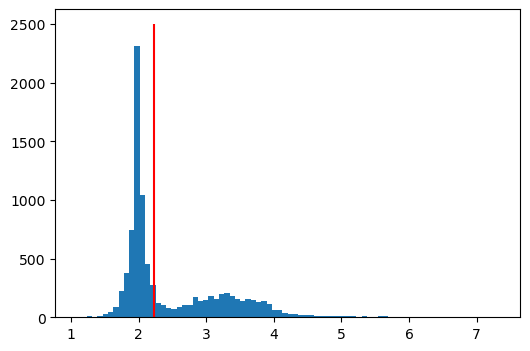

In [11]:
plt.rcParams["figure.figsize"] = (6,4)
plt.hist(absolute_ploidy, bins=80)
plt.vlines([ma], color='r', ymin=0, ymax=2500)
plt.savefig('../figures/ploidy_cutoff_selection.pdf')
plt.show()

In [12]:
absolute_ploidy_y.sum()/absolute_ploidy_y.count()

dichtomized_ploidy    0.388473
dtype: float64

In [13]:
tumor_order = list(tumor.join(absolute_ploidy).groupby('tumor').median().sort_values('ploidy', ascending=False).index)

In [14]:
coloring = (tumor.join(absolute_ploidy).groupby('tumor').median().sort_values('ploidy', ascending=False) > 2.5)

In [15]:
coloring['color'] = coloring['ploidy'].apply(lambda x: 'aquamarine' if x else 'whitesmoke')

/var/folders/j8/df8v0y1j16ng5mlcnmr38r0r0000gp/T/ipykernel_7303/2850431863.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tumor_order = list(df.groupby('tumor').median().sort_values('ploidy', ascending=False).index)


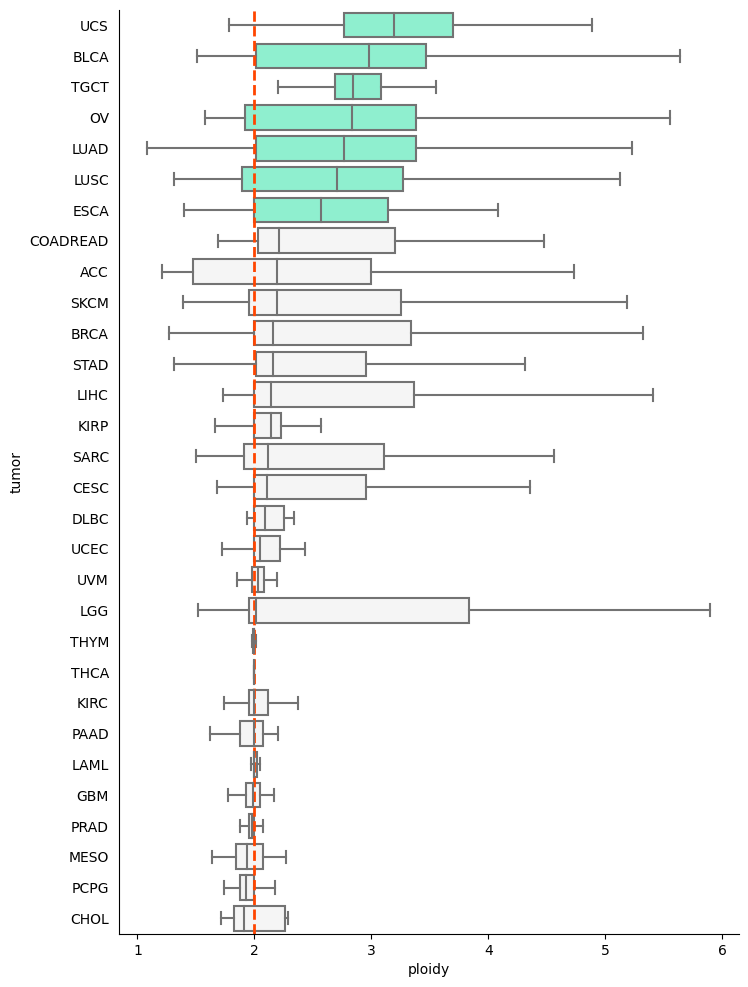

In [16]:
df = tumor.join(absolute_ploidy)
df['tumor'] = [x.upper() for x in list(df['tumor'].values)]
df['coloring'] = coloring['ploidy']
tumor_order = list(df.groupby('tumor').median().sort_values('ploidy', ascending=False).index)
plt.rcParams["figure.figsize"] = (8,12)
sns.boxplot(data=df, x='ploidy', y='tumor', order=tumor_order, color='w', palette=coloring['color'], showfliers=False)
plt.axvline(2, color='orangered', linestyle='--', linewidth=2)
plt.tick_params(axis='y', which='both',  left=False, top=False, labelleft=True)
sns.despine()
plt.savefig('../figures/ploidy_by_tumortype.pdf')

In [17]:
heterogeneity = pd.read_csv('../data/heterogeneity.tsv', delimiter=' ')
heterogeneity

,sample,patient_s,n_clonal,n_subclonal,total_nonsyn,heterogeneity
0,TCGA-02-0003-01A-01D-1490-08,TCGA-02-0003-01A-01D-1490-08,33,13,46,0.282609
1,TCGA-02-0033-01A-01D-1490-08,TCGA-02-0033-01A-01D-1490-08,19,9,28,0.321429
2,TCGA-02-0047-01A-01D-1490-08,TCGA-02-0047-01A-01D-1490-08,28,36,64,0.562500
3,TCGA-02-0055-01A-01D-1490-08,TCGA-02-0055-01A-01D-1490-08,39,9,48,0.187500
4,TCGA-02-2466-01A-01W-0837-08,TCGA-02-2466-01A-01W-0837-08,31,72,103,0.699029
...,...,...,...,...,...,...
9430,TCGA-ZS-A9CF-02A-11D-A382-10,TCGA-ZS-A9CF-02A-11D-A382-10,97,25,122,0.204918
9431,TCGA-ZS-A9CG-01A-11D-A36X-10,TCGA-ZS-A9CG-01A-11D-A36X-10,56,20,76,0.263158
9432,TCGA-ZT-A8OM-01A-11D-A428-09,TCGA-ZT-A8OM-01A-11D-A428-09,3,22,25,0.880000
9433,TCGA-ZU-A8S4-01A-11D-A417-09,TCGA-ZU-A8S4-01A-11D-A417-09,24,23,47,0.489362


In [108]:
model.device

device(type='cpu')

## Select genes

In [19]:
pca = PCA(n_components=50)
pca.fit(rna.values)

PCA(n_components=50)

In [20]:
pca_loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), index=rna.columns)

In [21]:
genes_pca = abs(pca_loadings).sum(axis=1).nlargest(1000).index

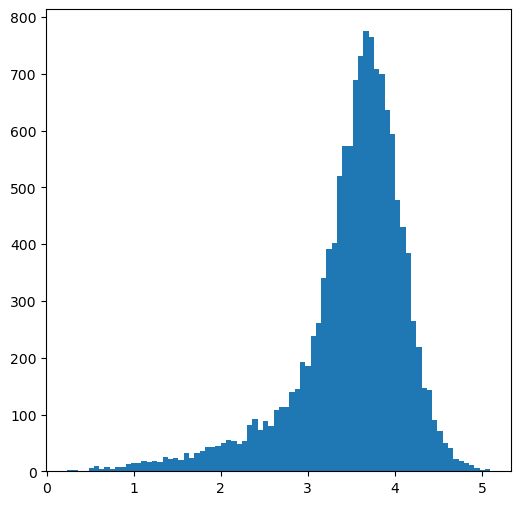

In [22]:
plt.rcParams["figure.figsize"] = (6,6)
plt.hist(abs(pca_loadings).sum(axis=1), bins=80)
plt.show()

## Run pnet

In [26]:
import Pnet

In [27]:
genetic_data = {'rna': rna[genes_pca]}

In [28]:
train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, absolute_ploidy_y)

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (6365, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (2727, 1000)


In [29]:
import ReactomeNetwork

In [30]:
reactome_network = ReactomeNetwork.ReactomeNetwork(train_dataset.get_genes())

Found 1000 overlapping genes


In [31]:
model = Pnet.PNET_NN(reactome_network=reactome_network, nbr_gene_inputs=len(genetic_data), dropout=0.2,
                      additional_dims=0, lr=1e-3, weight_decay=1)

In [32]:
train_loader, val_loader = pnet_loader.to_dataloader(train_dataset, test_dataset, 64)

In [33]:
import pytorch_lightning as pl

In [34]:
# trainer = pl.Trainer(precision=32, accelerator='cuda', max_epochs=100, log_every_n_steps=50, 
#                      enable_checkpointing=True)

# trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader,)

model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         absolute_ploidy_y,
                                                                         verbose=True,
                                                                         early_stopping=True)

Given 1 Input modalities
Found 9092 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (6365, 1000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (2727, 1000)
Found 1000 overlapping genes
Epoch 1 of 300
Train scores: (0.6739432260733558, 0.6120974076983503)
Test scores: (0.6616936205593622, 0.6087275394206088)
Epoch 2 of 300
Train scores: (0.6397367733628002, 0.48483896307934016)
Test scores: (0.6232348149365717, 0.3876054272093876)
Epoch 3 of 300
Train scores: (0.6227718038626384, 0.3190887666928515)
Test scores: (0.6096231539607004, 0.2687935460212688)
Epoch 4 of 300
Train scores: (0.6119116966685065, 0.2656716417910448)
Test scores: (0.6033645220016183, 0.22368903557022368)
Epoch 5 of 300
Train scores: (0.6062922118876922, 0.2589159465828751)
Test scores: (0.5981063192302507, 0.23945727906123945)
Epoch 6 of 300
Train scores: (0.6037252475591691, 0.25765907305577374)
Test scores: (0

In [35]:
x_train = train_dataset.x
additional_train = train_dataset.additional
y_train = train_dataset.y
x_test = test_dataset.x
additional_test = test_dataset.additional
y_test = test_dataset.y

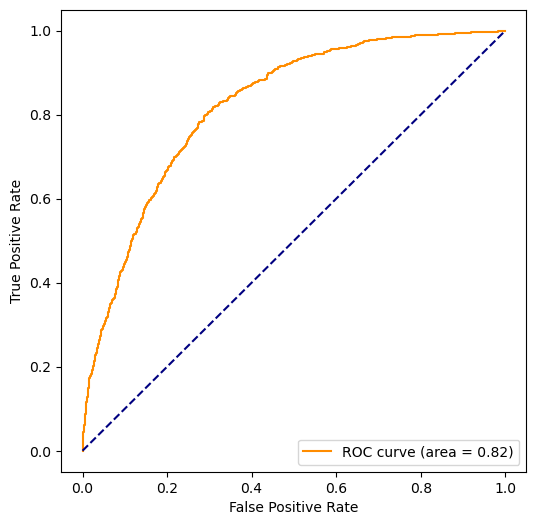

In [42]:
pred = model(x_test, additional_test)
y_pred_proba = pred.detach().numpy().squeeze()
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
test_auc = metrics.roc_auc_score(y_test, pred.detach().numpy().squeeze())
#create ROC curve
plt.plot(fpr,tpr, color="darkorange", label="ROC curve (area = %0.2f)" % test_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.legend(loc="lower right")
plt.savefig('PNET_ploidy_ROC_curve_rna_only.pdf')
plt.show()

### External Validation

In [37]:
ext_val_ploidy = pd.read_csv('../data/mel_dfci_2019/data_clinical_sample.txt',
                             delimiter='\t').set_index('Sample Identifier').iloc[4:]
ext_val_target = (ext_val_ploidy['Ploidy'].astype('float') > ma).astype('int')

In [39]:
inds = pnet_loader.get_indicies(genetic_data = {'rna': rna_ext_val[genes_pca]},
                                target=ext_val_target)
ext_val_dataset = pnet_loader.PnetDataset(genetic_data = {'rna': rna_ext_val[genes_pca]},
                                          target=ext_val_target, indicies=inds)

Found 121 overlapping indicies
Found 1000 overlapping genes
generated input DataFrame of size (121, 1000)


In [40]:
x_val = ext_val_dataset.x
additional_val = ext_val_dataset.additional
y_val = ext_val_dataset.y

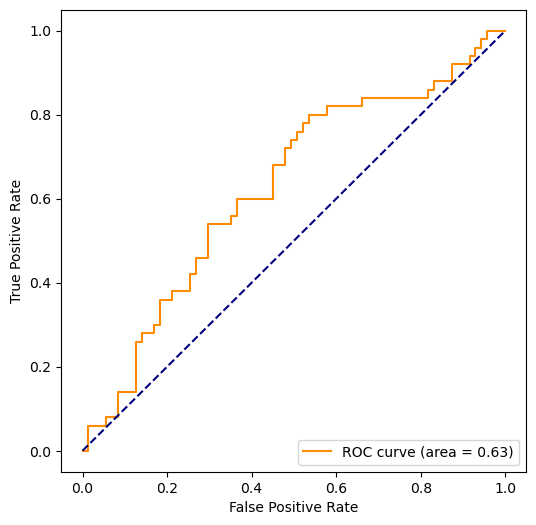

In [43]:
pred = model(x_val, additional_val)
y_pred_proba = pred.detach().numpy().squeeze()
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
test_auc = metrics.roc_auc_score(y_val, pred.detach().numpy().squeeze())
#create ROC curve
plt.plot(fpr,tpr, color="darkorange", label="ROC curve (area = %0.2f)" % test_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.legend(loc="lower right")
plt.savefig('PNET_ploidy_ROC_curve_ext_val_rna_only.pdf')
plt.show()

In [44]:
feature_importances, additional_importances = model.integrated_gradients(test_dataset)

In [51]:
feature_importances.sum().nlargest(20)

POC5        120.689145
TOE1        113.945805
WDR76       103.948810
CDK18       102.916479
MR1         102.339670
TAGLN       100.209361
RPL4         91.813087
FBXL5        89.261956
C16orf71     88.853988
REPIN1       85.818983
TSPAN3       82.250876
PWWP2A       75.207442
BCL7A        72.407136
PTMA         62.602751
FBXO36       61.157005
PTPRCAP      59.644888
TSNAXIP1     57.923517
HARS         56.175618
HDAC3        55.739594
FBXO42       51.759455
dtype: float64

In [52]:
layerwise_imps = model.layerwise_importance(test_dataset)

In [53]:
for l in layerwise_imps:
    print(l.nlargest(5))

Gluconeogenesis                                                  20.799564
Major pathway of rRNA processing in the nucleolus and cytosol     8.783642
rRNA modification in the nucleus and cytosol                      2.481303
Antigen processing: Ubiquitination & Proteasome degradation       0.164913
Response of EIF2AK4 (GCN2) to amino acid deficiency               0.087017
dtype: float32
Heme signaling                                        37.348900
Anchoring of the basal body to the plasma membrane    30.850626
Intraflagellar transport                              27.835035
Protein methylation                                   22.504049
Glucose metabolism                                    20.789555
dtype: float32
Iron uptake and transport                  89.062851
Cilium Assembly                            60.447666
Post-translational protein modification    42.937241
Membrane Trafficking                       32.335323
Cellular responses to stress               31.438164
dtype: flo

<AxesSubplot: xlabel='POC5', ylabel='Density'>

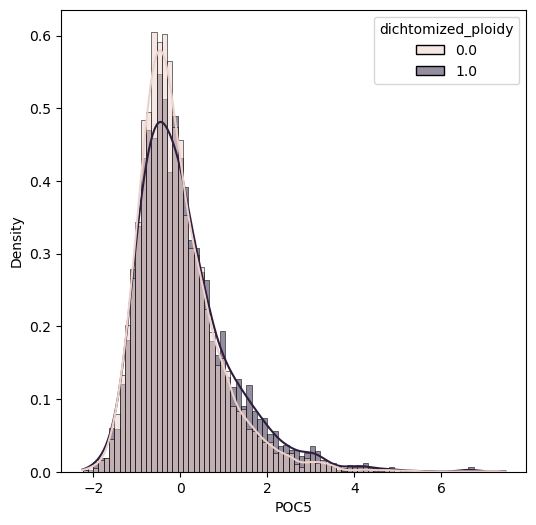

In [106]:
sns.histplot(data=rna.join(absolute_ploidy_y), x='POC5', hue='dichtomized_ploidy',bins=80,
             stat='density', kde=True, common_norm=False)

In [ ]:
gene_order = high_ploidy_importances.median().sort_values(ascending=True).index
gene_order

In [ ]:
high_ploidy_importances = gene_importances[gene_importances.join(absolute_ploidy_y)['dichtomized_ploidy'] == 1]

In [ ]:
plt.rcParams["figure.figsize"] = (6,8)
high_ploidy_importances[list(gene_order[-20:])].plot(kind='box', vert=False, showfliers=False)
plt.savefig('../figures/genes_ploidy.pdf')
plt.show()

In [ ]:
pathway_importances = model.layerwise_importance(test_dataset)

In [ ]:
for l in pathway_importances:
    print(l.nlargest(5))

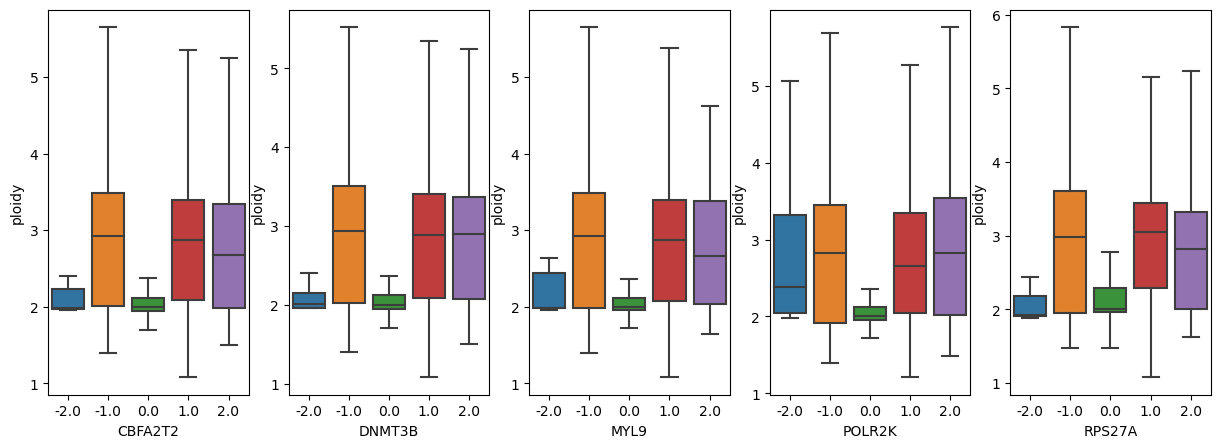

In [69]:
some_genes = ['CBFA2T2', 'DNMT3B', 'MYL9', 'POLR2K', 'RPS27A']
fig, axs = plt.subplots(1, 5, figsize=((15, 5)))
for i, gene in enumerate(some_genes):
    gene = gene.split('_')[0]
    sns.boxplot(data=cna.join(absolute_ploidy), x=gene, y='ploidy', ax=axs[i], showfliers=False)
plt.savefig('../figures/cna_vs_ploiy_top_genes.pdf')
plt.show()

In [81]:
pred = torch.sigmoid(model(x_test, additional_test))

In [82]:
pred_ = pd.DataFrame(pred.detach().numpy(), index=test_dataset.input_df.index, columns=['prediction'])

In [83]:
pred_.join(tumor)

,prediction,tumor
TCGA-KQ-A41Q-01,0.591419,blca
TCGA-WB-A80N-01,0.187834,pcpg
TCGA-FA-A4XK-01,0.377260,dlbc
TCGA-EJ-5526-01,0.227813,prad
TCGA-DK-A6B6-01,0.457677,blca
...,...,...
TCGA-FE-A3PB-01,0.174474,thca
TCGA-26-5133-01,0.470625,gbm
TCGA-KV-A6GE-01,0.421287,kirp
TCGA-D9-A1JW-06,0.453414,skcm


In [95]:
df['tumor'].values[0].upper()

'BLCA'

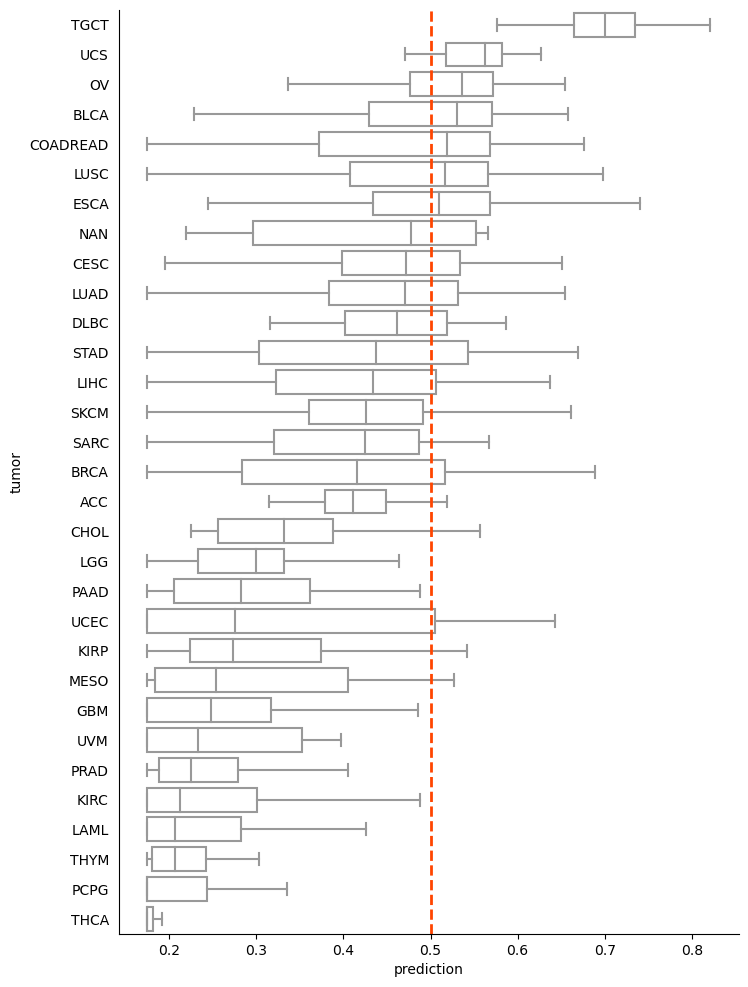

In [100]:
df = pred_.join(tumor)
df['tumor'] = [str(x).upper() for x in df['tumor'].values]
tumor_order = list(df.groupby('tumor').median().sort_values('prediction', ascending=False).index)
plt.rcParams["figure.figsize"] = (8,12)
sns.boxplot(df, x='prediction', y='tumor', order=tumor_order, color='w', showfliers=False)
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.tick_params(axis='y', which='both',  left=False, top=False, labelleft=True)
sns.despine()
plt.savefig('../figures/prediction_by_tumortype.pdf')

In [103]:
missclass_df.groupby('tumor').mean()

,prediction,dichtomized_ploidy,misclass
tumor,,,
acc,0.411977,0.428571,0.380952
blca,0.480079,0.638655,0.277311
brca,0.400389,0.509434,0.342767
cesc,0.458409,0.364706,0.376471
chol,0.346802,0.200000,0.100000
coadread,0.467952,0.491803,0.245902
dlbc,0.459572,0.235294,0.352941
esca,0.489336,0.596491,0.280702
gbm,0.275600,0.114286,0.142857


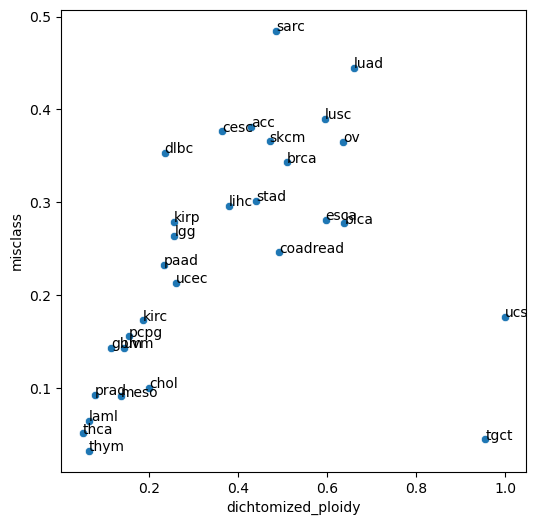

In [102]:
plt.rcParams["figure.figsize"] = (6,6)
missclass_df = pred_.join(tumor).join(test_dataset.target)
missclass_df['misclass'] = missclass_df.apply(lambda x: 1-int(round(x['prediction'])==x['dichtomized_ploidy']), axis=1)
sns.scatterplot(missclass_df.groupby('tumor').mean(), x='dichtomized_ploidy', y='misclass')
for tum in missclass_df.groupby('tumor').mean().index:
    plt.annotate(missclass_df.groupby('tumor').mean().loc[tum].name,
                (missclass_df.groupby('tumor').mean().loc[tum]['dichtomized_ploidy'],
                 missclass_df.groupby('tumor').mean().loc[tum]['misclass']))
plt.savefig('../figures/ploidy_vs_misclass_by_tumortype.pdf')

## Multiple runs

In [ ]:
def fold_run(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(x,
                                                                             y,
                                                                             verbose=False,
                                                                             early_stopping=True)

        x_train = train_dataset.input_df.astype(float).values
        additional_train = train_dataset.additional_data.astype(float).values
        y_train = train_dataset.target.astype(float).values.reshape(-1)
        x_test = test_dataset.input_df.astype(float).values
        additional_test = test_dataset.additional_data.astype(float).values
        y_test = test_dataset.target.astype(float).values.reshape(-1)

        pred = model(torch.tensor(x_test, dtype=torch.float),
                                  torch.tensor(additional_test, dtype=torch.float)
                    )
        y_pred_proba = pred.detach().numpy().squeeze()
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        test_auc = metrics.roc_auc_score(y_test, pred.detach().numpy().squeeze())

        aucs.append(test_auc)

        gene_importances, additional_importances = model.deepLIFT(test_dataset)
        most_imp_genes.append(gene_importances.sum())
    return aucs, most_imp_genes

In [ ]:
def fold_run_rf(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        train_dataset, test_dataset = pnet_loader.generate_train_test(x, y, None, None, 0.3, None)
        clf = RandomForestClassifier()
        clf.fit(train_dataset.input_df.values, train_dataset.target.values.reshape(-1))
        
        x_train = train_dataset.input_df.astype(float).values
        additional_train = train_dataset.additional_data.astype(float).values
        y_train = train_dataset.target.astype(float).values.reshape(-1)
        x_test = test_dataset.input_df.astype(float).values
        additional_test = test_dataset.additional_data.astype(float).values
        y_test = test_dataset.target.astype(float).values.reshape(-1)

        y_pred_proba = clf.predict_proba(x_test)
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba[:,1])
        test_auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])

        aucs.append(test_auc)

        gene_importances = clf.feature_importances_
        most_imp_genes.append(pd.DataFrame(clf.feature_importances_, index=test_dataset.input_df.columns))
    return aucs, most_imp_genes

In [ ]:
ploidy_absolut_auc, ploidy_absolut_genes = fold_run(genetic_data, absolute_ploidy_y, 10)
ploidy_absolut_auc_rf, ploidy_absolut_genes_rf = fold_run_rf(genetic_data, absolute_ploidy_y, 10)

In [ ]:
data_pnet = [ploidy_absolut_auc]
data_rf = [ploidy_absolut_auc_rf]

ticks = ['ploidy \n by absolut']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
    
bpl = plt.boxplot(data_pnet, positions=np.array(range(len(data_pnet)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_rf, positions=np.array(range(len(data_pnet)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

plt.plot([], c='#D7191C', label='pnet')
plt.plot([], c='#2C7BB6', label='rf')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.savefig('absolute_ploidy_auc_pnet_vs_rf.pdf')

In [ ]:
ploidy_absolut_genes

In [ ]:
ploidy_absolut_genes_rf

In [ ]:
gene_order = pd.DataFrame(ploidy_absolut_genes).mean().sort_values(ascending=False).index
df_sum = pd.DataFrame(ploidy_absolut_genes)

In [ ]:
gene_order_rf = pd.DataFrame([x[0] for x in ploidy_absolut_genes_rf]).mean().sort_values(ascending=False).index
df_sum_rf = pd.DataFrame([x[0] for x in ploidy_absolut_genes_rf])

In [ ]:
plt.rcParams["figure.figsize"] = (6,8)
df_sum[list(gene_order[:20]) + list(gene_order[-20:])].plot(kind='box', vert=False)
plt.savefig('Ploidy_important_genes.pdf')
plt.show()

In [ ]:
def check_annotate(x, y):
    if y > 1e-3/(x)**1.9 + 1e-3:
        return True
    else:
        return False

In [ ]:
import scipy.stats as ss

In [ ]:
comb_df['pnet_rank'] = ss.rankdata(comb_df['pnet_imp'])
comb_df['rf_rank'] = ss.rankdata(comb_df['rf_imp'])

In [ ]:
comb_df = pd.DataFrame([df_sum.mean(), df_sum_rf.mean()]).T
comb_df.columns = ['pnet_imp', 'rf_imp']
comb_df['pnet_rank'] = len(comb_df['pnet_imp']) - ss.rankdata(abs(comb_df['pnet_imp']))
comb_df['rf_rank'] = len(comb_df['rf_imp']) - ss.rankdata(abs(comb_df['rf_imp']))
comb_df['annotate'] = comb_df.apply(lambda x: x['pnet_rank'] + x['rf_rank'] < 100, axis=1)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(comb_df['pnet_imp'], comb_df['rf_imp'], s=10)

for i in range(len(comb_df)):
    if comb_df.iloc[i]['annotate']:
        ax.annotate(comb_df.iloc[i].name, (comb_df.iloc[i]['pnet_imp'], comb_df.iloc[i]['rf_imp']))

plt.ylabel('rf importance')
plt.xlabel('pnet importance')
plt.title('Ploidy classification gene importance')
plt.savefig('important_genes_ploidy_scatter.pdf')
plt.show()

In [ ]:
import gseapy as gp

In [ ]:
def prerank_gsea(gene_importances, gene_list):
    gene_sets='../data/reactome/ReactomePathways.gmt'
    gene_importance_scores = pd.DataFrame(index=gene_list)
    gene_importance_scores['1'] = gene_importances.values.reshape((2,-1)).sum(axis=0)
        
    pre_res = gp.prerank(rnk=gene_importance_scores,
                         gene_sets = gene_sets,
                         threads=8,
                         min_size=5,
                         max_size=1000,
                         permutation_num=1000,
                         outdir='../prerank_gsea',
                         seed=6,
                         verbose=True
                        )
    return pre_res

In [ ]:
pre_res_rf = prerank_gsea(comb_df['rf_imp'], list(comb_df.iloc[:int(comb_df.shape[0]/2)].index))

In [ ]:
top_hits_rf = list(pre_res_rf.res2d.sort_values('NOM p-val').head(15)['Term'])

In [ ]:
top_hits_rf

In [ ]:
pre_res_pnet = prerank_gsea(comb_df['pnet_imp'], list(comb_df.iloc[:int(comb_df.shape[0]/2)].index))

In [ ]:
top_hits_pnet = list(pre_res_pnet.res2d.sort_values('NOM p-val').head(15)['Term'])

In [ ]:
top_hits_pnet